In [17]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap
import pandas as pd
from geopandas import GeoDataFrame
from shapely.geometry import Point
import fiona
from matplotlib import collections  as mc

In [ ]:
#getting started https://jakevdp.github.io/PythonDataScienceHandbook/04.13-geographic-data-with-basemap.html

In [1]:
plt.figure(figsize=(8, 8))
m = Basemap(projection='ortho', resolution=None, lat_0=50, lon_0=-100)
m.bluemarble(scale=0.5);
print("")

NameError: name 'plt' is not defined

## Prepare Tow Data; coordinates to floats, calculate bounding box

In [18]:
#read in points from file
df1 = pd.read_csv('../data/raw/IBS2_First_2_Years/Tow_Info.csv')
df2 = pd.read_csv('../data/raw/IBS2_First_2_Years/tow_info_201880.csv')
tow_df = df1.append( df2, ignore_index=True ).dropna()

tow_df['slon'] =  tow_df.apply(lambda row: float((row["START_LON"]).replace('W','')) / -100, axis=1) 
tow_df['slat'] =  tow_df.apply(lambda row: float((row["START_LAT"]).replace('N','')) / 100, axis=1) 
tow_df['elon'] =  tow_df.apply(lambda row: float((row["END_LON"]).replace('W','')) / -100, axis=1) 
tow_df['elat'] =  tow_df.apply(lambda row: float((row["END_LAT"]).replace('N','')) / 100, axis=1) 
tow_df['pdate'] = tow_df.apply(lambda row: pd.to_datetime( row['START_TIME'] ), axis=1 )
tow_df['month'] = tow_df.apply(lambda row: row['pdate'].month , axis=1 )


tow_df['dist'] = ((tow_df['slon'] - tow_df['elon'])**2 + (tow_df['slat'] - tow_df['elat'])**2) ** 0.5
tow_df = tow_df.loc[tow_df['dist'] < .1]

lats = [ i for i in tow_df['slat'] ]
lons = [ i for i in tow_df['slon'] ]

llcrnrlon = min(lons)
llcrnrlat = min(lats)
urcrnrlon = max(lons)
urcrnrlat = max(lats)
box = [ llcrnrlon, llcrnrlat, urcrnrlon, urcrnrlat ]
print(box)


[-70.51364, 41.47909, -69.30295, 43.438689999999994]


In [19]:
def get_zone( obj ):
    coords = [ (obj['slat'] + obj['elat'])/2 , (obj['slon'] + obj['elon'])/2 ]    
    if coords[0] < 41.72:
        zone=3
    if coords[0] > 42.75:
        if coords[1] > -69.77:
            zone=1
        else:
            zone=5
    else:
        if coords[1] > -69.77:
            zone=2        
        else:
            zone=4
    return zone

tow_df['zone'] = tow_df.apply(lambda row: get_zone(row) , axis=1 )

In [23]:
def winter( obj ):
    if obj['month'] == 1 or obj['month'] > 9:
        return 1
    else:
        return 0
tow_df['winter'] = tow_df.apply(lambda row: winter(row) , axis=1 )

set([1, 4, 5, 6, 7, 10, 11, 12])


In [24]:
tow_df.head(20)

,OPERATION_ID,OPERATION_STATUS,CRUISE_ID,SITE_NAME,START_TIME,START_LAT,START_LON,END_TIME,END_LAT,END_LON,slon,slat,elon,elat,pdate,month,dist,zone,winter
0,2,Representative,"201,682",1-52 ALT,6/10/2016 10:54:51 PM,4333.933N,06958.789W,6/10/2016 11:15:11 PM,4333.234N,06959.755W,-69.58789,43.33933,-69.59755,43.33234,2016-06-10 22:54:51,6,0.011924,1,0
1,3,Representative,"201,680",8-32,4/18/2016 11:11:17 AM,4212.849N,07019.059W,4/18/2016 11:41:24 AM,4214.227N,07018.776W,-70.19059,42.12849,-70.18776,42.14227,2016-04-18 11:11:17,4,0.014068,4,0
2,3,Representative,"201,681",7-29,5/9/2016 9:15:05 AM,4212.533N,07035.072W,5/9/2016 9:45:04 AM,4211.655N,07033.639W,-70.35072,42.12533,-70.33639,42.11655,2016-05-09 09:15:05,5,0.016806,4,0
3,3,Representative,"201,682",3-8,6/11/2016 10:55:19 AM,4326.682N,06932.646W,6/11/2016 11:25:19 AM,4325.466N,06933.877W,-69.32646,43.26682,-69.33877,43.25466,2016-06-11 10:55:19,6,0.017303,1,0
4,4,Representative,"201,680",8-34,4/18/2016 1:44:38 PM,4209.141N,07003.976W,4/18/2016 2:15:03 PM,4207.861N,07003.031W,-70.03976,42.09141,-70.03031,42.07861,2016-04-18 13:44:38,4,0.015910,4,0
5,4,Representative,"201,681",8-32,5/9/2016 11:01:37 AM,4205.920N,07028.067W,5/9/2016 11:31:57 AM,4204.992N,07026.694W,-70.28067,42.05920,-70.26694,42.04992,2016-05-09 11:01:37,5,0.016572,4,0
6,4,Representative,"201,682",3-14,6/11/2016 12:58:09 PM,4318.918N,06939.632W,6/11/2016 1:28:01 PM,4317.619N,06940.425W,-69.39632,43.18918,-69.40425,43.17619,2016-06-11 12:58:09,6,0.015219,1,0
7,4,Representative,"201,683",8-35,7/1/2016 10:19:13 AM,4215.743N,07027.206W,7/1/2016 10:49:14 AM,4214.900N,07025.618W,-70.27206,42.15743,-70.25618,42.14900,2016-07-01 10:19:13,7,0.017979,4,0
8,4,Representative,"201,780",8-17 APR,4/8/2017 11:50:23 AM,4207.596N,07028.918W,4/8/2017 12:20:22 PM,4206.191N,07028.167W,-70.28918,42.07596,-70.28167,42.06191,2017-04-08 11:50:23,4,0.015931,4,0
9,4,Representative,"201,781",8-19 OCT,10/1/2017 12:55:05 PM,4203.579N,07000.648W,10/1/2017 1:25:04 PM,4204.562N,07001.900W,-70.00648,42.03579,-70.01900,42.04562,2017-10-01 12:55:05,10,0.015918,4,1


### lookup sea surface temperature and bathymetry data

In [20]:
import subprocess

def get_sst( obj ):
    date = tuple([ obj["pdate"].year, obj["pdate"].month])
    coords = [ str((obj['slat'] + obj['elat'])/2) , str((obj['slon'] + obj['elon'])/2 ) ]
    
    sstfile = "../data/raw/aquaMODIS-L2-sst/{}-{}.tiff".format( date[0], str(date[1]).zfill(2) )
    
    test = subprocess.Popen(["gdallocationinfo",
                            "-valonly",
                            "-wgs84",
                            sstfile,
                            coords[1],
                            coords[0]
                            ], stdout=subprocess.PIPE)  
    output = test.communicate()
    val = float(output[0].decode("utf-8"))
    cel = ((val / 255) * 47) -2
    
    return cel

def get_bth( obj ):
    try:
        coords = [ str((obj['slat'] + obj['elat'])/2) , str((obj['slon'] + obj['elon'])/2 ) ]
        test = subprocess.Popen(["gdallocationinfo",
                            "-valonly",
                            "-wgs84",
                            "../data/raw/bathymetry/bathymetry.tif",
                            coords[1],
                            coords[0]
                            ], stdout=subprocess.PIPE)  
        output = test.communicate()
        bth = float(output[0].decode("utf-8"))
        return bth if bth <= 0 else 0
    except:
        return 400
    

tow_df['sst'] =  tow_df.apply(lambda row: get_sst( row ), axis=1)
tow_df['bth'] =  tow_df.apply(lambda row: get_bth( row ), axis=1) 

ValueError: ('could not convert string to float: ', u'occurred at index 0')

In [77]:
tow_df = tow_df.loc[tow_df['dist'] < .1]
tow_df.count()

OPERATION_ID        835
OPERATION_STATUS    835
CRUISE_ID           835
SITE_NAME           835
START_TIME          835
START_LAT           835
START_LON           835
END_TIME            835
END_LAT             835
END_LON             835
slon                835
slat                835
elon                835
elat                835
pdate               835
dist                835
sst                 835
bth                 835
dtype: int64

### read in fish data; append tow data to fish records

In [78]:
fish_df = pd.read_csv('../data/raw/reorg.csv').dropna()
fish_df.count()

ORGANISM_ID     2897
CRUISE_ID       2897
maturity        2897
OPERATION_ID    2897
length          2897
sex             2897
dtype: int64

In [79]:
fishtow_df = pd.merge(fish_df, tow_df, how='inner', on=['OPERATION_ID', 'CRUISE_ID'] )
fishtow_df.count()

ORGANISM_ID         2793
CRUISE_ID           2793
maturity            2793
OPERATION_ID        2793
length              2793
sex                 2793
OPERATION_STATUS    2793
SITE_NAME           2793
START_TIME          2793
START_LAT           2793
START_LON           2793
END_TIME            2793
END_LAT             2793
END_LON             2793
slon                2793
slat                2793
elon                2793
elat                2793
pdate               2793
dist                2793
sst                 2793
bth                 2793
dtype: int64

In [85]:
#write dataframe to csv for ml step
fishtow_df.columns

ml_df = fishtow_df.drop(['OPERATION_STATUS', 'SITE_NAME',
                        'START_TIME', 'START_LON', 'START_LAT',
                         'END_TIME', 'END_LAT', 'END_LON','dist',
                         'OPERATION_ID', 'CRUISE_ID', 
                         ###maybe add back - see notes
                         'slon','slat','elon','elat','pdate'
                        ], axis=1)
ml_df.head()
outfile = '../data/processed/fishtow.csv'
ml_df.to_csv(outfile, sep=',', encoding='utf-8')

#### distribution of tows distances, remove erroneous data

/home/local/AZVA-INT/lmckinstry/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


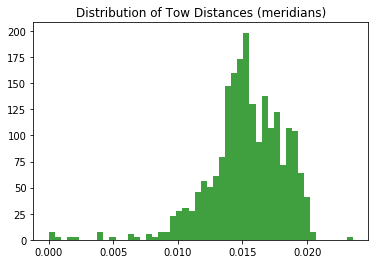

In [65]:
tow_df['dist'] = ((tow_df['slon'] - tow_df['elon'])**2 + (tow_df['slat'] - tow_df['elat'])**2) ** 0.5
(min(tow_df['dist']), max(tow_df['dist']), sum(tow_df['dist'])/len(tow_df['dist'])  )

plt.hist(tow_df['dist'], 50, normed=1, facecolor='green', alpha=0.75)
plt.title('Distribution of Tow Distances (meridians)')
plt.savefig( '../data/raw/Tow_Distance_hist.png' )
plt.show()


In [10]:
#explore dates

dates = [ tuple([i.year, i.month]) for i in tow_df['pdate']]
d_set = list(set(dates))
sort = sorted(d_set, key = lambda x: (x[0], x[1]))
sort


[(2016, 4),
 (2016, 5),
 (2016, 6),
 (2016, 7),
 (2016, 10),
 (2016, 11),
 (2016, 12),
 (2017, 1),
 (2017, 4),
 (2017, 5),
 (2017, 6),
 (2017, 7),
 (2017, 10),
 (2017, 11),
 (2017, 12),
 (2018, 1),
 (2018, 4),
 (2018, 5),
 (2018, 6),
 (2018, 7)]

### plot all tows

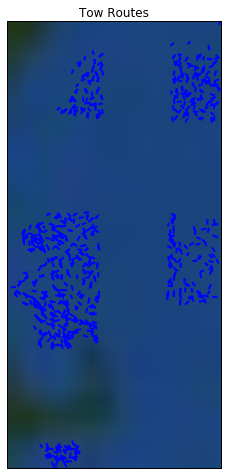

In [20]:

def get_arc( row ):
    return ( 
        row['slon'], row['slat'], row['elon'], row['elat'] )

fig = plt.figure(figsize=(8, 8))
m = Basemap(projection='cass', resolution='i', llcrnrlon=box[0], llcrnrlat=box[1],
            urcrnrlon=box[2], urcrnrlat=box[3], 
            width=8E6, height=8E6, 
            lat_0=43.260511, lon_0=-68.299058,)  #43.260511, -68.299058
m.bluemarble()
#m.drawcoastlines()

# Map (long, lat) to (x, y) for plotting
#plt.plot()

for index, row in tow_df.iterrows():
    try:
        arc = get_arc(row)
        
        m.drawgreatcircle(arc[0],arc[1],arc[2],arc[3],linewidth=2,color='b')
    except:
        pass

#x, y = m(lons, lats)
#plt.plot(x, y, 'ok', markersize=5)
plt.title('Tow Routes')

plt.savefig( '../data/raw/Tow_Routes_zoomin.png' )
#plt.text(x, y, ' Seattle', fontsize=12);
plt.show()

### plot tows by month

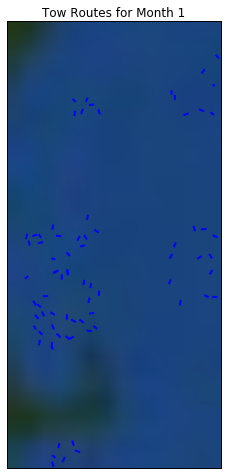

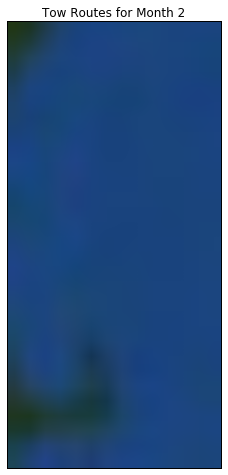

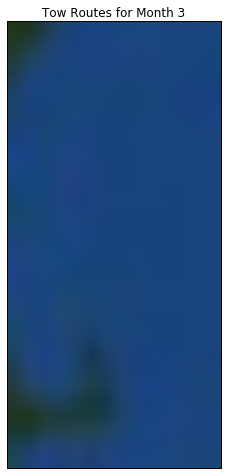

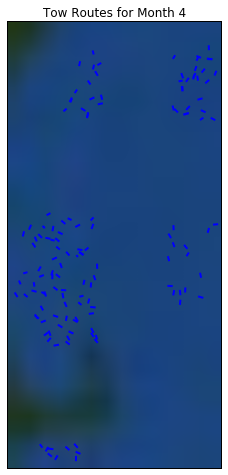

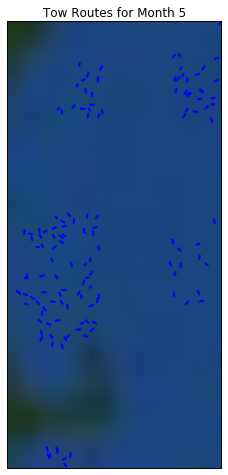

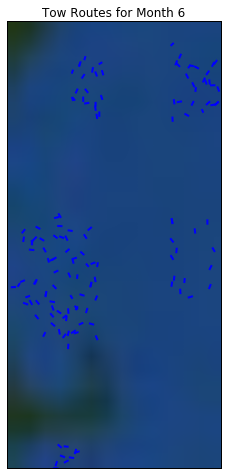

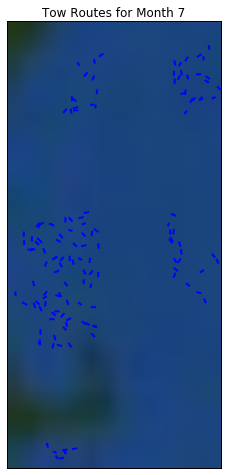

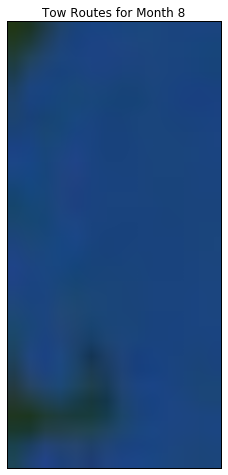

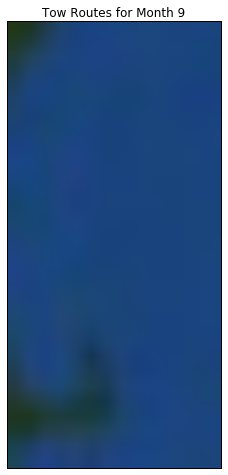

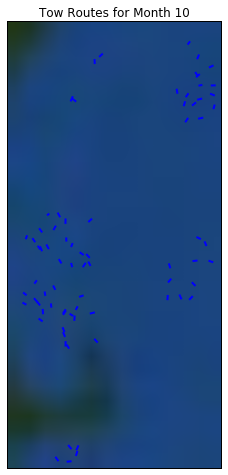

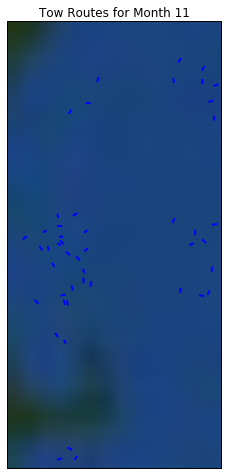

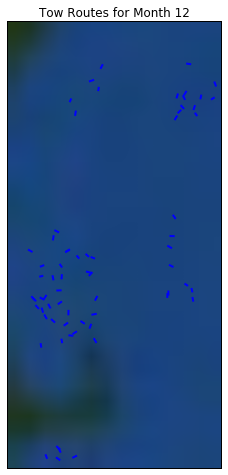

In [48]:
#Color by month
#m.drawcoastlines()
# Map (long, lat) to (x, y) for plotting
#plt.plot()

for this_month in range(1,13):
    fig = plt.figure(figsize=(8, 8))
    m = Basemap(projection='cass', resolution='i', llcrnrlon=box[0], llcrnrlat=box[1],
                urcrnrlon=box[2], urcrnrlat=box[3], 
                width=8E6, height=8E6, 
                lat_0=43.260511, lon_0=-68.299058,)  #43.260511, -68.299058
    m.bluemarble()
    counter = 0
    for index, row in tow_df.iterrows():
        
        if row['pdate'].to_datetime().month == this_month:
            try:
                arc = get_arc(row)
                m.drawgreatcircle(arc[0],arc[1],arc[2],arc[3],linewidth=2,color='b')
            except:
                raise ValueError('A very specific bad thing happened.')
                
    #print( 'month', this_month )

    plt.title('Tow Routes for Month {0}'.format(this_month) )
    plt.savefig( '../data/raw/month_routes/Tow_Routes_month{0}.png'.format(this_month) )
#     plt.show()

### distribution of tows by month

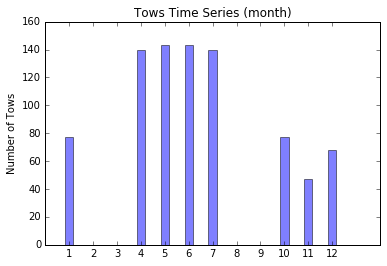

In [68]:
#show dist of tows in calendar year
y_pos = np.arange(1,13)
tows = []
for this_month in range(1,13):
    tows.append( len([ i.to_datetime().month for i in tow_df['pdate'] if i.to_datetime().month == this_month]))
plt.bar(y_pos, tows, bar_width, align='center', alpha=0.5)
plt.xticks(y_pos, y_pos)
plt.ylabel('Number of Tows')
plt.title('Tows Time Series (month)')
plt.savefig( '../data/raw/month_routes/Tow_month_distribution.png')
plt.show()